In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import random
import torch.nn as nn
import timm
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.transforms import v2


import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import math # Nodig voor LR berekening
from torchvision import models
import torch.nn as nn
from collections import OrderedDict
import torch
import timm

import torch.optim as optim
import torch.nn.functional as F # Importeer dit!
import torch
import torch.nn as nn
from torchvision import models
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from functools import partial

import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F # Nodig voor adaptive_avg_pool2d
import torchvision.models as models
import timm
import pandas as pd
import os
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer # Nodig voor data voorbereiding
from collections import OrderedDict # Nodig voor state_dict
from torch.optim.lr_scheduler import CosineAnnealingLR # Nodig voor scheduler
from tqdm import tqdm # Nodig voor progress bar
from sklearn.metrics import roc_auc_score # Nodig voor AUROC berekening


/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# 1. Stel de random seed in voor Python's random module
random.seed(42)

# 2. Stel de random seed in voor NumPy
np.random.seed(42)

# 3. Stel de random seed in voor PyTorch
torch.manual_seed(42)

# Voor CUDA (indien je een GPU gebruikt) 
torch.cuda.manual_seed(42)

In [4]:
import torch

# Laad het checkpoint
checkpoint = torch.load('./weights_chexnet/model.pth')

# Haal de state_dict eruit
state_dict = checkpoint['state_dict']

# Print de eerste paar keys van de state_dict om de structuur te bekijken
for i, key in enumerate(state_dict.keys()):
    print(key)
    if i > 5:  # Print de eerste 6 keys
        break

module.densenet121.features.conv0.weight
module.densenet121.features.norm0.weight
module.densenet121.features.norm0.bias
module.densenet121.features.norm0.running_mean
module.densenet121.features.norm0.running_var
module.densenet121.features.denseblock1.denselayer1.norm.1.weight
module.densenet121.features.denseblock1.denselayer1.norm.1.bias


In [5]:
class CheXpertDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)

        # Always convert to RGB to ensure 3 input channels for the model
        image = image.convert('RGB')

        # Gebruik de oorspronkelijke aanpak met iloc als de ge-encodeerde CSV exact deze structuur heeft
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.convert('RGB')
        labels = self.df.iloc[idx, 1:].values.astype('float32') # Labels zijn de rest na kolom 0


        if self.transform:
            image = self.transform(image)

        return image, labels


# Load CSVs
df_train = pd.read_csv('./data/train_labels.csv')  # bevat kolommen 'image_path' en 'labels'
df_val = pd.read_csv('./data/val_labels.csv')
df_test = pd.read_csv('./data/test_labels.csv')
# Convert to string and split multi-label strings
df_train['Finding Labels'] = df_train['Finding Labels'].astype(str).str.split('|')
df_val['Finding Labels'] = df_val['Finding Labels'].astype(str).str.split('|')
df_test['Finding Labels'] = df_test['Finding Labels'].astype(str).str.split('|')

# One-hot encode labels
mlb = MultiLabelBinarizer()
label_matrix_train = mlb.fit_transform(df_train['Finding Labels'])
label_matrix_val = mlb.fit_transform(df_val['Finding Labels'])
label_matrix_test = mlb.fit_transform(df_test['Finding Labels'])

# Add the one-hot encoded labels to the Dataframe
label_df_train = pd.DataFrame(label_matrix_train, columns=mlb.classes_)
df_train = pd.concat([df_train[['Image Index']], label_df_train], axis=1)

label_df_val = pd.DataFrame(label_matrix_val, columns=mlb.classes_)
df_val = pd.concat([df_val[['Image Index']], label_df_val], axis=1)

label_df_test = pd.DataFrame(label_matrix_test, columns=mlb.classes_)
df_test = pd.concat([df_test[['Image Index']], label_df_test], axis=1)

df_train.to_csv('./data/train_labels_encoded.csv', index=False)
df_val.to_csv('./data/val_labels_encoded.csv', index=False)
df_test.to_csv('./data/test_labels_encoded.csv', index=False)

# Transformaties voor de trainingsset (inclusief augmentatie)
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomRotation(degrees=15),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    # Use 3-channel normalization matching ImageNet if you are using ImageNet pretraining
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaties voor de validatie- en testsets (alleen resizing en tensor conversie)
val_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    # Use 3-channel normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creëer de Datasets
train_dataset = CheXpertDataset(csv_file='./data/train_labels_encoded.csv', root_dir='./data/train', transform=train_transforms)
val_dataset = CheXpertDataset(csv_file='./data/val_labels_encoded.csv', root_dir='./data/val', transform=val_transforms)
test_dataset = CheXpertDataset(csv_file='./data/test_labels_encoded.csv', root_dir='./data/test', transform=val_transforms)

# Creëer de DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers= os.cpu_count(),pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count(),pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count(),pin_memory=True)

print('Samples train (*batchsize):',(len(train_loader)))
print('Samples val  (*batchsize):',(len(val_loader)))
print('Samples test  (*batchsize):',(len(test_loader)))
# subset
from torch.utils.data import Dataset, Subset, DataLoader
# Creëer de volledige dataset
full_train_dataset = CheXpertDataset(csv_file='./data/train_labels_encoded.csv', root_dir='./data/train', transform=train_transforms)
full_val_dataset = CheXpertDataset(csv_file='./data/val_labels_encoded.csv', root_dir='./data/val', transform=val_transforms)
# Definieer de grootte van de subset
subset_size_train = 100
subset_size_val = 10

# Genereer willekeurige indices
all_indices_train = list(range(len(full_train_dataset)))
random.shuffle(all_indices_train)
subset_indices_train = all_indices_train[:subset_size_train]

# Genereer willekeurige indices
all_indices_val= list(range(len(full_val_dataset)))
random.shuffle(all_indices_val)
subset_indices_val = all_indices_val[:subset_size_val]

# Creëer de subset met de willekeurige indices
train_subset = Subset(full_train_dataset, subset_indices_train)
val_subset = Subset(full_val_dataset, subset_indices_val)

# Gebruik de subset DataLoader
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader_subset = DataLoader(val_subset, batch_size=32, shuffle=True)

print('Samples subset train (*batchsize):',(len(train_loader_subset)))
print('Samples subset val  (*batchsize):',(len(val_loader_subset)))

Samples train (*batchsize): 2429
Samples val  (*batchsize): 276
Samples test  (*batchsize): 800
Samples subset train (*batchsize): 4
Samples subset val  (*batchsize): 1


/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, num_mlp_heads=3, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        self.num_mlp_heads = num_mlp_heads

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.heads = nn.ModuleList()
        if num_mlp_heads > 0:
            self.heads2 = nn.ModuleList()
        if num_mlp_heads > 1:
            self.heads3 = nn.ModuleList()
        if num_mlp_heads > 2:
            self.heads4 = nn.ModuleList()
        if num_mlp_heads > 0:
            self.relu = nn.ReLU()     # for 1 or more heads
        for i in range(num_classes):
            if num_mlp_heads == 0:
                self.heads.append(nn.Linear(self.num_features, 2))
            if num_mlp_heads == 1:
                self.heads.append(nn.Linear(self.num_features, 48))
                self.heads2.append(nn.Linear(48, 2))
            if num_mlp_heads == 2:
                self.heads.append(nn.Linear(self.num_features, 384))
                self.heads2.append(nn.Linear(384, 48))
                self.heads3.append(nn.Linear(48, 2))
            if num_mlp_heads == 3:
                self.heads.append(nn.Linear(self.num_features, 384))
                self.heads2.append(nn.Linear(384, 48))
                self.heads3.append(nn.Linear(48, 48))
                self.heads4.append(nn.Linear(48, 2))

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        y = []
        for i in range(len(self.heads)):
            if self.num_mlp_heads == 0:
                y.append(self.heads[i](x))
            if self.num_mlp_heads == 1:
                y.append(self.heads2[i](self.relu(self.heads[i](x))))
            if self.num_mlp_heads == 2:
                y.append(self.heads3[i](self.relu(self.heads2[i](self.relu(self.heads[i](x))))))
            if self.num_mlp_heads == 3:
                y.append(self.heads4[i](self.relu(self.heads3[i](self.relu(self.heads2[i](self.relu(self.heads[i](x))))))))
        return y

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [7]:
def to_2tuple(x):
    return (x, x) if isinstance(x, int) else x

class SequentialCheXNetSwin(nn.Module):
    def __init__(self, num_classes=15, img_size=224, chexnet_weights_path='./weights_chexnet/model.pth', swin_weights_path='./weights_swinchex/swin_base_patch4_window7_224_22k.pth'):
        super().__init__()
        self.img_size = img_size
        self.num_classes = num_classes # Het aantal klassen dat JIJ wilt classificeren (hier 15)

        # --- CNN Backbone (Pretrained CheXNet DenseNet121 op CXR14) ---
        # ... (Deze code blijft hetzelfde) ...
        self.cnn_backbone = models.densenet121(pretrained=False)
        chexnet_checkpoint = torch.load(chexnet_weights_path, map_location=torch.device('cpu'))
        original_chexnet_weights = chexnet_checkpoint['state_dict']
        state_dict_to_load_cnn = OrderedDict()
        for k, v in original_chexnet_weights.items():
             name = k
             if name.startswith('module.'):
                 name = name[len('module.'):]
             if name.startswith('densenet121.'):
                 name = name[len('densenet121.'):]
             if any(prefix in name for prefix in ['features.', 'avgpool']):
                  state_dict_to_load_cnn[name] = v
        try:
             self.cnn_backbone.load_state_dict(state_dict_to_load_cnn, strict=False)
             print(f"CheXNet gewichten geladen vanuit {chexnet_weights_path} in CNN backbone (strict=False).")
        except RuntimeError as e:
             print(f"Waarschuwing bij het laden van CheXNet gewichten: {e}. Sommige sleutels voor CNN backbone kwamen mogelijk niet overeen.")

        self.cnn_backbone.classifier = nn.Identity()
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
        self.cnn_backbone.eval()
        print("CNN backbone (CheXNet) gewichten bevroren.")


        # --- Swin Transformer Backbone (Gebruikt originele code SwinTransformer) ---
        print(f"Initialiseer Swin Transformer model structuur met originele code en laad gewichten van bestand: {swin_weights_path}")


        # --- Projectie Laag (CNN Feature Maps -> Swin Input Shape) ---
        # Past de shape van de CNN feature maps aan naar de verwachte input shape van de Swin.
        with torch.no_grad(): # Voer dit uit zonder gradients te berekenen
            dummy_input = torch.randn(1, 3, img_size, img_size)
            cnn_dummy_out = self.cnn_backbone.features(dummy_input)
            cnn_out_channels = cnn_dummy_out.shape[1]
            cnn_out_h = cnn_dummy_out.shape[2]
            cnn_out_w = cnn_dummy_out.shape[3]
            print(f"DenseNet features output shape: (B, {cnn_out_channels}, {cnn_out_h}, {cnn_out_w})")

        self.projection_layer = nn.Sequential(
            # 1x1 Conv om kanalen aan te passen van CNN output naar Swin input (3 kanalen)
            nn.Conv2d(cnn_out_channels, 3, kernel_size=1),
            # Upsample om ruimtelijke resolutie aan te passen (bv van 7x7 naar 224x224)
            nn.Upsample(size=(img_size, img_size), mode='bilinear', align_corners=False)
            # Optioneel: Voeg hier een activatiefunctie toe na de Conv, zoals nn.ReLU()
        )
        # Standaard zijn de parameters van nieuwe lagen (zoals deze) trainbaar.
        print(f"Projectie laag toegevoegd ({cnn_out_channels}x{cnn_out_h}x{cnn_out_w} -> {3}x{img_size}x{img_size}).")


        # --- Swin MLP Backbone (Getraind op ImageNet-21k, ZONDER originele Classifier) ---
        # We gebruiken de SwinMLP klasse die je hebt gedeeld.
        print(f"Initialiseer Swin MLP model structuur (zonder classifier) en laad gewichten van bestand: {swin_weights_path}")

        # Initialiseer SwinMLP ZONDER classifier door num_classes=0 te zetten.
        # De overige parameters moeten overeenkomen met de architectuur van het checkpoint.
        self.swin_backbone = SwinTransformer ( # <-- Gebruik de SwinMLP klasse hier
            img_size=img_size,
            patch_size=4,
            in_chans=3, # Ontvangt 3 kanalen van de projectielaag
            num_classes=0, # <-- BELANGRIJK: Vertel SwinMLP om GEEN classifier aan te maken!
            embed_dim=128, # Swin-Base parameter
            depths=[2, 2, 18, 2], # Swin-Base parameter
            num_heads=[4, 8, 16, 32], # Swin-Base parameter
            window_size=7, # Swin-Base parameter
            mlp_ratio=4.,
            drop_rate=0.,
            attn_drop_rate=0.,
            # drop_path_rate hier afstemmen op wat tijdens de ImageNet-21k pre-training is gebruikt.
            # Jouw eerdere code had 0.5, de gedeelde SwinMLP code had 0.1.
            # Gebruik 0.1 als je de SwinMLP code precies gebruikt.
            drop_path_rate=0.1, # Pas dit zo nodig aan
            norm_layer=nn.LayerNorm,
            ape=False, # Swin-Base gebruikt meestal geen APE
            patch_norm=True,
            use_checkpoint=False,
        )

        # --- LAAD HIER DE SPECIFIEKE SWIN GEWICHTEN VAN HET BESTAND ---
        # Dit laadt de backbone gewichten van het ImageNet-21k checkpoint.
        # strict=False is essentieel omdat de originele 21841-output classifier niet bestaat in ons model (num_classes=0).
        # De foutmelding over 'head' is verwacht en negeren we hierdoor.
        if swin_weights_path and os.path.exists(swin_weights_path):
             try:
                 print(f"Poging tot laden van Swin MLP gewichten vanuit {swin_weights_path}...")
                 swin_checkpoint = torch.load(swin_weights_path, map_location=torch.device('cpu'), weights_only=False)

                 swin_state_dict = None
                 if isinstance(swin_checkpoint, dict):
                     if 'model' in swin_checkpoint:
                         swin_state_dict = swin_checkpoint['model']
                     elif 'state_dict' in swin_checkpoint:
                         swin_state_dict = swin_checkpoint['state_dict']
                     else:
                         swin_state_dict = swin_checkpoint

                 if swin_state_dict is not None:
                     # STRICT=FALSE is CRUCIAAL. De 'head' gewichten met 21841 outputs worden hierdoor overgeslagen.
                     missing_keys, unexpected_keys = self.swin_backbone.load_state_dict(swin_state_dict, strict=False)
                     print(f"Swin MLP gewichten succesvol geladen vanuit {swin_weights_path} (strict=False).")
                     # We verwachten nu dat keys zoals 'head.weight' en 'head.bias' in missing_keys staan. Dit is correct.
                     print(f"Waarschuwing: Swin MLP missende sleutels (verwacht als originele classifier ontbreekt): {missing_keys}")
                     if unexpected_keys: print(f"Waarschuwing: Swin MLP onverwachte sleutels: {unexpected_keys}")
                 else:
                     print(f"Fout: Kon geen state_dict vinden in {swin_weights_path}.")

             except Exception as e:
                 print(f"Fout bij het laden van Swin MLP gewichten vanuit {swin_weights_path}: {e}")
        else:
             print(f"Waarschuwing: Swin gewichten bestand niet gevonden op {swin_weights_path}. Swin MLP backbone is niet geladen met een specifiek bestand.")


        # Bevries de parameters van de Swin MLP backbone.
        # De geladen ImageNet-21k gewichten blijven bevroren.
        for param in self.swin_backbone.parameters():
             param.requires_grad = False
        self.swin_backbone.eval()
        print("Swin MLP backbone parameters zijn bevroren.")

        # Bepaal de output dimensie van swin_backbone.forward_features().
        # Dit is de grootte van de feature vector die de Swin backbone produceert.
        # Dit is de input dimensie voor ONZE NIEUWE classificatiekop.

        with torch.no_grad():
            # Gebruik de dummy output van de CNN backbone als input voor de projectielaag test
            # cnn_dummy_out werd eerder berekend: (B, 1024, 7, 7)
            dummy_proj_output = self.projection_layer(cnn_dummy_out) # <-- Corrected dummy input
            # forward_features() retourneert de output VÓÓR de (hier niet-bestaande) originele head.
            dummy_swin_feat = self.swin_backbone.forward_features(dummy_proj_output)
            self.swin_output_dim = dummy_swin_feat.shape[-1] # De laatste dimensie is de feature grootte (meestal 1024 voor Swin-Base)
        print(f"Swin MLP backbone output dimension (voor ONZE nieuwe classifier): {self.swin_output_dim}")


        # --- ONZE NIEUWE Classifier ---
        # Deze module is de classificatiekop die wij toevoegen.
        # Hij neemt de output van SwinMLP.forward_features() als input.
        # Hij wordt willekeurig geïnitialiseerd en getraind voor jouw 15 klassen.
        self.classifier = nn.Sequential(
            # De input size is de output size van de Swin MLP backbone features.
            nn.Linear(self.swin_output_dim, 512), # Voorbeeld: een verborgen laag
            nn.ReLU(True),
            nn.Dropout(0.5),
            # De output size is het JUISTE aantal klassen voor jouw taak (self.num_classes = 15).
            nn.Linear(512, num_classes), # --> Eindlaag met 15 outputs
            nn.Sigmoid() # Sigmoid voor multi-label classificatie (onafhankelijke waarschijnlijkheid per klasse)
        )

        # De parameters van de projectielaag en ONZE nieuwe classifier zijn standaard trainbaar.
        # We zetten ze expliciet op True voor de duidelijkheid.
        for param in self.projection_layer.parameters():
             param.requires_grad = True
        for param in self.classifier.parameters():
             param.requires_grad = True

        print("Projectie laag en ONZE nieuwe Classifier parameters zijn trainbaar.")


    def forward(self, x):
        # De forward pass van het hele SequentialCheXNetSwin model

        # Input x is de afbeelding (B, 3, H, W)

        # 1. Stuur de afbeelding door de bevroren CNN backbone feature extractor.
        # Output: feature maps (B, 1024, H', W')
        cnn_intermediate_features = self.cnn_backbone.features(x)

        # 2. Stuur de CNN features door de trainbare projectielaag.
        # Output: "afbeelding-achtige" features (B, 3, img_size, img_size)
        projected_features = self.projection_layer(cnn_intermediate_features)

        # 3. Stuur de geprojecteerde features door de bevroren Swin MLP backbone.
        # We gebruiken forward_features om de gepoolde feature vector te krijgen,
        # VÓÓR de (niet-bestaande/overgeslagen) originele Swin MLP classifier.
        # Output: gepoolde feature vector (B, swin_output_dim)
        swin_feat = self.swin_backbone.forward_features(projected_features)

        # 4. Stuur de Swin features door ONZE NIEUWE trainbare classifier.
        # Output: de eindvoorspellingen voor de 15 klassen (B, num_classes) na Sigmoid.
        output = self.classifier(swin_feat)

        return output

In [8]:
model = SequentialCheXNetSwin(
    num_classes=15, # Zorg dat dit overeenkomt met je dataset labels
    img_size=224, # Zorg dat dit overeenkomt met je transforms en het Swin model
    chexnet_weights_path='./weights_chexnet/model.pth', # Pad naar je CheXNet gewichten
    swin_weights_path= './weights_swinchex/swin_base_patch4_window7_224_22k.pth' # Pad naar je Swinchex gewichten
)

# Verplaats het model naar het juiste device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CheXNet gewichten geladen vanuit ./weights_chexnet/model.pth in CNN backbone (strict=False).
CNN backbone (CheXNet) gewichten bevroren.
Initialiseer Swin Transformer model structuur met originele code en laad gewichten van bestand: ./weights_swinchex/swin_base_patch4_window7_224_22k.pth
DenseNet features output shape: (B, 1024, 7, 7)
Projectie laag toegevoegd (1024x7x7 -> 3x224x224).
Initialiseer Swin MLP model structuur (zonder classifier) en laad gewichten van bestand: ./weights_swinchex/swin_base_patch4_window7_224_22k.pth


/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Poging tot laden van Swin MLP gewichten vanuit ./weights_swinchex/swin_base_patch4_window7_224_22k.pth...
Swin MLP gewichten succesvol geladen vanuit ./weights_swinchex/swin_base_patch4_window7_224_22k.pth (strict=False).
Waarschuwing: Swin MLP missende sleutels (verwacht als originele classifier ontbreekt): []
Waarschuwing: Swin MLP onverwachte sleutels: ['head.weight', 'head.bias']
Swin MLP backbone parameters zijn bevroren.
Swin MLP backbone output dimension (voor ONZE nieuwe classifier): 1024
Projectie laag en ONZE nieuwe Classifier parameters zijn trainbaar.


In [9]:
# -----------------------------------------------------------------------------
epochs = 300
warmup_epochs = 20
base_lr = 5e-4
warmup_lr = 5e-7
min_lr = 5e-6
weight_decay = 0.05
clip_grad = 5.0
auto_resume = True
accumulation_steps = 0 # Overgenomen uit config. Let op: 0 of 1 betekent geen accumulatie.
patience = 20

optimizer_name = 'adamw' # Overgenomen uit config
optimizer_eps = 1e-8 # Overgenomen uit config
optimizer_betas = (0.9, 0.999) # Overgenomen uit config
# optimizer_momentum = 0.9 # Niet gebruikt voor AdamW

# -----------------------------------------------------------------------------
# Initialisatie en Hervatting
# -----------------------------------------------------------------------------
# Performance lists - blijven hetzelfde
train_preds = []
train_labels = []
val_preds = []
val_labels = []
train_losses = []
val_losses = []
val_aurocs = []

# Define checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_val_auroc = 0.0
trigger_times = 0
scheduler = None # Declare scheduler here, initialize later

# Instellen van de Optimizer
# Gebruik de overgenomen parameters
if optimizer_name.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, betas=optimizer_betas, eps=optimizer_eps, weight_decay=weight_decay)
# elif optimizer_name.lower() == 'sgd':
#     # Indien SGD uit de config kwam, zou je deze code gebruiken met momentum en base_lr
#     # optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=optimizer_momentum, weight_decay=weight_decay)
else:
    # Voeg hier andere optimizers toe indien nodig, of geef een foutmelding
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")


# Instellen van de Scheduler na warmup
# De CosineAnnealingLR zal worden gebruikt voor de periode na de warmup
# T_max is het aantal epochs voor de cosine decay.
# We starten met BASE_LR en eindigen bij MIN_LR.
if epochs > warmup_epochs:
    # Initialiseer de scheduler die actief wordt na de warmup periode
    # De 'initial_lr' voor de scheduler is de LR op het moment dat de scheduler begint (BASE_LR)
    # De scheduler past de LR van de optimizer aan.
    # Voor CosineAnnealingLR na een warmup begint het 'cosine' deel effectief vanaf base_lr.
    # T_max is hier het aantal EPOCHS voor de decay.
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs, eta_min=min_lr)


# Automatisch hervatten vanaf het laatste checkpoint
if auto_resume:
    latest_checkpoint_path = None
    best_checkpoint_path = os.path.join(checkpoint_dir, 'best_auroc.pth')

    # Zoek het meest recente epoch-checkpoint
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')]
    if checkpoints:
        # Sorteer op epoch nummer
        checkpoints.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
        latest_checkpoint_file = checkpoints[-1]
        latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint_file)
        print(f"Found latest epoch checkpoint: {latest_checkpoint_path}")

    if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
        try:
            print(f"Loading checkpoint '{latest_checkpoint_path}'")
            checkpoint = torch.load(latest_checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            # Probeer ook de scheduler state te laden als deze bestaat
            if 'scheduler_state_dict' in checkpoint and scheduler is not None:
                 scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                 print("Scheduler state loaded.")
            print(f"Resumed from epoch {start_epoch}")

            # Laad de beste AUROC uit het 'best_auroc.pth' bestand als het bestaat
            if os.path.exists(best_checkpoint_path):
                 best_checkpoint = torch.load(best_checkpoint_path, map_location=device)
                 # Gebruik .get() voor robuustheid als 'val_auroc' sleutel ontbreekt
                 best_val_auroc = best_checkpoint.get('val_auroc', 0.0)
                 print(f"Loaded best validation AUROC ({best_val_auroc:.4f}) from {best_checkpoint_path}")
            else:
                 # Als best_auroc.pth niet bestaat, initialiseren we best_val_auroc op 0.0
                 best_val_auroc = 0.0
                 print("No best_auroc.pth found. Initializing best_val_auroc to 0.0")


        except Exception as e:
            print(f"Could not load checkpoint: {e}. Starting training from scratch.")
            start_epoch = 0 # Reset naar start als laden mislukt
            best_val_auroc = 0.0 # Reset beste AUROC

    else:
        print("No latest epoch checkpoint found or auto_resume is False. Starting training from scratch.")
        start_epoch = 0
        best_val_auroc = 0.0 # Initialiseer de beste validatie AUROC

print(f"Starting training from epoch {start_epoch+1}/{epochs}")


# -----------------------------------------------------------------------------
# Training loop
# -----------------------------------------------------------------------------
for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0
    train_steps = len(train_loader)
    epoch_train_preds = []
    epoch_train_labels = []

    # Handmatige LR aanpassing voor warmup (tot en met warmup_epochs - 1)
    if epoch < warmup_epochs:
        # Lineaire warmup van warmup_lr naar base_lr over warmup_epochs
        # De factor (epoch / warmup_epochs) gaat van 0 naar (warmup_epochs-1)/warmup_epochs
        lr_factor = epoch / max(1, warmup_epochs) # max(1, ...) om deling door nul te voorkomen als warmup_epochs=0
        current_lr = warmup_lr + (base_lr - warmup_lr) * lr_factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    # Let op: De LR na warmup wordt door de scheduler beheerd. De scheduler.step()
    # wordt na de validatie aangeroepen.

    pbar = tqdm(enumerate(train_loader), total=train_steps, desc=f"Epoch {epoch+1}/{epochs} [TRAIN] LR: {optimizer.param_groups[0]['lr']:.6f}")
    for step, (inputs, targets) in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Nulstel gradients alleen aan het begin van een accumulatie cyclus
        # accumulation_steps == 0 of 1 betekent geen accumulatie, dan altijd zero_grad()
        if accumulation_steps <= 1 or (step % accumulation_steps == 0):
             optimizer.zero_grad()

        outputs = model(inputs)
        criterion = torch.nn.BCELoss()
        # Verplaats de criterion naar het juiste apparaat (GPU of CPU)
        criterion = criterion.to(device)
        loss = criterion(outputs, targets)

        # Scale de loss als we accumuleren (alleen als accumulation_steps > 1)
        if accumulation_steps > 1:
            loss = loss / accumulation_steps

        loss.backward()

        # Gradient Clipping (indien ingeschakeld)
        if clip_grad > 0:
             torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        # Optimizer stap en nulstellen van gradients na accumulatie stappen
        # of bij elke stap als accumulation_steps <= 1
        if accumulation_steps <= 1 or (step + 1) % accumulation_steps == 0 or (step + 1) == train_steps:
             optimizer.step()
             # zero_grad() wordt aan het begin van de volgende cyclus/epoch gedaan


        # Voeg loss toe voor gemiddelde berekening.
        # Als er geaccumuleerd wordt, is loss al geschaald, dus vermenigvuldig terug.
        # Als er niet geaccumuleerd wordt, is loss niet geschaald, en vermenigvuldigen met 1.
        train_loss += loss.item() * max(1, accumulation_steps)

        epoch_train_preds.extend(outputs.cpu().detach().numpy())
        epoch_train_labels.extend(targets.cpu().detach().numpy())

        # Update progress bar met de huidige LR
        # De getoonde loss moet het gemiddelde per "echte" batch zijn.
        # train_loss is de som van geschaalde losses * accumulation_steps.
        # step + 1 is het aantal batches dat verwerkt is.
        # train_loss / (step + 1) geeft de gemiddelde loss per batch.
        pbar.set_postfix({'loss': train_loss / (step + 1), 'lr': optimizer.param_groups[0]['lr']})


    avg_train_loss = train_loss / train_steps
    train_losses.append(avg_train_loss)
    train_preds.append(np.array(epoch_train_preds))
    train_labels.append(np.array(epoch_train_labels))

    # -------------------------------------------------------------------------
    # Validatie fase
    # -------------------------------------------------------------------------
    model.eval()
    val_loss = 0
    val_steps = len(val_loader)
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        for step, (inputs, targets) in tqdm(enumerate(val_loader), total=val_steps, desc=f"Epoch {epoch+1}/{epochs} [VAL]"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            epoch_val_preds.extend(outputs.cpu().detach().numpy())
            epoch_val_labels.extend(targets.cpu().detach().numpy())

    avg_val_loss = val_loss / val_steps
    val_losses.append(avg_val_loss)

    val_preds.append(np.array(epoch_val_preds))
    val_labels.append(np.array(epoch_val_labels))

    # --- AUROC BEREKENING ---
    y_true_np = np.array(epoch_val_labels)
    y_preds_np = np.array(epoch_val_preds)

    try:
        # Controleer of er meer dan 1 unieke klasse is om AUROC te kunnen berekenen
        if y_true_np.size > 0 and len(np.unique(y_true_np)) > 1:
            avg_val_auroc = roc_auc_score(y_true_np, y_preds_np, average='macro')
        else:
            # AUROC is ongedefinieerd als er 0 grootte is of slechts 1 unieke klasse
            print("Cannot compute AUROC: Validation set is empty or contains only one class.")
            avg_val_auroc = np.nan # Zet op NaN als berekening niet mogelijk is

    except ValueError as e:
        print(f"Could not calculate AUROC for this epoch: {e}")
        avg_val_auroc = np.nan # Zet op NaN als berekening mislukt

    val_aurocs.append(avg_val_auroc)
    # --- EINDE AUROC BEREKENING ---

    # --- LR Scheduler Step (na de validatie) ---
    # Pas de LR scheduler aan na de epoch als de warmup voorbij is
    if epoch >= warmup_epochs and scheduler is not None:
        # De scheduler.step() past de LR aan voor de *volgende* epoch
        scheduler.step()
        print(f"Scheduler stepped. Next epoch LR will be: {optimizer.param_groups[0]['lr']:.6f}")
    elif epoch < warmup_epochs:
         # Tijdens warmup tonen we de LR die voor de huidige epoch is ingesteld
         print(f"Warmup epoch {epoch+1}/{warmup_epochs}. Current LR: {optimizer.param_groups[0]['lr']:.6f}")


    # Print de berekende metrics
    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val AUROC = {avg_val_auroc:.4f}" if not np.isnan(avg_val_auroc) else f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val AUROC: N/A")


    # --- Checkpoint opslaan en Early Stopping ---
    # Sla het beste model op gebaseerd op validatie AUROC (als het geldig is)
    if not np.isnan(avg_val_auroc):
        if avg_val_auroc > best_val_auroc:
            best_val_auroc = avg_val_auroc
            best_checkpoint_path = os.path.join(checkpoint_dir, 'best_auroc.pth')
            save_dict = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_auroc': best_val_auroc
            }
            if scheduler is not None:
                 save_dict['scheduler_state_dict'] = scheduler.state_dict()

            torch.save(save_dict, best_checkpoint_path)
            trigger_times = 0
            print(f"Validation AUROC improved. Saving best checkpoint with AUROC: {best_val_auroc:.4f} to {best_checkpoint_path}")
        else:
            trigger_times += 1
            print(f"Validation AUROC did not improve. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1} (no improvement in Val AUROC). Best Val AUROC: {best_val_auroc:.4f}")
                break # Verlaat de training loop

    else:
        # Als AUROC niet berekend kan worden, resetten we de early stopping teller
        print("Skipping early stopping check because Val AUROC is NaN.")
        # Je kunt trigger_times hier resetten of niet, afhankelijk van hoe je om wilt gaan
        # met periodes waar AUROC niet berekenbaar is. Resetten is veiliger.
        trigger_times = 0


    # Sla periodieke checkpoints op
    # Sla ook het laatste checkpoint altijd op bij het einde van de training (epoch == epochs - 1)
    if (epoch + 1) % 20 == 0 or (epoch + 1) == epochs:
        epoch_checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
        save_dict = {
             'epoch': epoch + 1,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'val_loss': avg_val_loss,
             'val_auroc': avg_val_auroc # Sla de AUROC van deze epoch op in het periodieke checkpoint
        }
        if scheduler is not None: 
             save_dict['scheduler_state_dict'] = scheduler.state_dict()

        torch.save(save_dict, epoch_checkpoint_path)
        print(f"Periodic checkpoint saved at epoch {epoch + 1}: {epoch_checkpoint_path}")

print("Training finished.")

No latest epoch checkpoint found or auto_resume is False. Starting training from scratch.
Starting training from epoch 1/300


Epoch 1/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.49it/s]


Warmup epoch 1/20. Current LR: 0.000000
Epoch 1/300: Train Loss = 0.5324 | Val Loss = 0.4086 | Val AUROC = 0.4919
Validation AUROC improved. Saving best checkpoint with AUROC: 0.4919 to checkpoints/best_auroc.pth


Epoch 2/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.53it/s]


Warmup epoch 2/20. Current LR: 0.000025
Epoch 2/300: Train Loss = 0.2077 | Val Loss = 0.1913 | Val AUROC = 0.5516
Validation AUROC improved. Saving best checkpoint with AUROC: 0.5516 to checkpoints/best_auroc.pth


Epoch 3/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.50it/s]


Warmup epoch 3/20. Current LR: 0.000050
Epoch 3/300: Train Loss = 0.1997 | Val Loss = 0.1885 | Val AUROC = 0.5770
Validation AUROC improved. Saving best checkpoint with AUROC: 0.5770 to checkpoints/best_auroc.pth


Epoch 4/300 [VAL]: 100%|██████████| 276/276 [00:41<00:00,  6.58it/s]


Warmup epoch 4/20. Current LR: 0.000075
Epoch 4/300: Train Loss = 0.1971 | Val Loss = 0.1865 | Val AUROC = 0.5941
Validation AUROC improved. Saving best checkpoint with AUROC: 0.5941 to checkpoints/best_auroc.pth


Epoch 5/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.55it/s]


Warmup epoch 5/20. Current LR: 0.000100
Epoch 5/300: Train Loss = 0.1953 | Val Loss = 0.1854 | Val AUROC = 0.6174
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6174 to checkpoints/best_auroc.pth


Epoch 6/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.46it/s]


Warmup epoch 6/20. Current LR: 0.000125
Epoch 6/300: Train Loss = 0.1945 | Val Loss = 0.1847 | Val AUROC = 0.6196
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6196 to checkpoints/best_auroc.pth


Epoch 7/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.51it/s]


Warmup epoch 7/20. Current LR: 0.000150
Epoch 7/300: Train Loss = 0.1941 | Val Loss = 0.1851 | Val AUROC = 0.6303
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6303 to checkpoints/best_auroc.pth


Epoch 8/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.54it/s]


Warmup epoch 8/20. Current LR: 0.000175
Epoch 8/300: Train Loss = 0.1937 | Val Loss = 0.1838 | Val AUROC = 0.6433
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6433 to checkpoints/best_auroc.pth


Epoch 9/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.52it/s]


Warmup epoch 9/20. Current LR: 0.000200
Epoch 9/300: Train Loss = 0.1935 | Val Loss = 0.1851 | Val AUROC = 0.6520
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6520 to checkpoints/best_auroc.pth


Epoch 10/300 [VAL]: 100%|██████████| 276/276 [00:41<00:00,  6.57it/s]


Warmup epoch 10/20. Current LR: 0.000225
Epoch 10/300: Train Loss = 0.1935 | Val Loss = 0.1838 | Val AUROC = 0.6545
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6545 to checkpoints/best_auroc.pth


Epoch 11/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.57it/s]


Warmup epoch 11/20. Current LR: 0.000250
Epoch 11/300: Train Loss = 0.1932 | Val Loss = 0.1841 | Val AUROC = 0.6536
Validation AUROC did not improve. Patience: 1/20


Epoch 12/300 [VAL]: 100%|██████████| 276/276 [00:41<00:00,  6.59it/s]


Warmup epoch 12/20. Current LR: 0.000275
Epoch 12/300: Train Loss = 0.1935 | Val Loss = 0.1835 | Val AUROC = 0.6578
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6578 to checkpoints/best_auroc.pth


Epoch 13/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.54it/s]

Warmup epoch 13/20. Current LR: 0.000300
Epoch 13/300: Train Loss = 0.1934 | Val Loss = 0.1829 | Val AUROC = 0.6528
Validation AUROC did not improve. Patience: 1/20



Epoch 14/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.49it/s]


Warmup epoch 14/20. Current LR: 0.000325
Epoch 14/300: Train Loss = 0.1933 | Val Loss = 0.1830 | Val AUROC = 0.6543
Validation AUROC did not improve. Patience: 2/20


Epoch 15/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.56it/s]


Warmup epoch 15/20. Current LR: 0.000350
Epoch 15/300: Train Loss = 0.1934 | Val Loss = 0.1823 | Val AUROC = 0.6581
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6581 to checkpoints/best_auroc.pth


Epoch 16/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.49it/s]

Warmup epoch 16/20. Current LR: 0.000375
Epoch 16/300: Train Loss = 0.1932 | Val Loss = 0.1823 | Val AUROC = 0.6551
Validation AUROC did not improve. Patience: 1/20



Epoch 17/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.54it/s]


Warmup epoch 17/20. Current LR: 0.000400
Epoch 17/300: Train Loss = 0.1930 | Val Loss = 0.1828 | Val AUROC = 0.6646
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6646 to checkpoints/best_auroc.pth


Epoch 18/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.54it/s]


Warmup epoch 18/20. Current LR: 0.000425
Epoch 18/300: Train Loss = 0.1930 | Val Loss = 0.1820 | Val AUROC = 0.6754
Validation AUROC improved. Saving best checkpoint with AUROC: 0.6754 to checkpoints/best_auroc.pth


Epoch 19/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.50it/s]

Warmup epoch 19/20. Current LR: 0.000450
Epoch 19/300: Train Loss = 0.1931 | Val Loss = 0.1825 | Val AUROC = 0.6703
Validation AUROC did not improve. Patience: 1/20



Epoch 20/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.57it/s]


Warmup epoch 20/20. Current LR: 0.000475
Epoch 20/300: Train Loss = 0.1932 | Val Loss = 0.1828 | Val AUROC = 0.6643
Validation AUROC did not improve. Patience: 2/20
Periodic checkpoint saved at epoch 20: checkpoints/epoch_20.pth


Epoch 21/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.53it/s]

Scheduler stepped. Next epoch LR will be: 0.000475
Epoch 21/300: Train Loss = 0.1928 | Val Loss = 0.1820 | Val AUROC = 0.6658
Validation AUROC did not improve. Patience: 3/20



Epoch 22/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.56it/s]

Scheduler stepped. Next epoch LR will be: 0.000475
Epoch 22/300: Train Loss = 0.1926 | Val Loss = 0.1815 | Val AUROC = 0.6717
Validation AUROC did not improve. Patience: 4/20



Epoch 23/300 [VAL]: 100%|██████████| 276/276 [00:42<00:00,  6.52it/s]

Scheduler stepped. Next epoch LR will be: 0.000475
Epoch 23/300: Train Loss = 0.1924 | Val Loss = 0.1815 | Val AUROC = 0.6663
Validation AUROC did not improve. Patience: 5/20



Epoch 24/300 [TRAIN] LR: 0.000475:   6%|▌         | 140/2429 [00:45<12:21,  3.09it/s, loss=0.192, lr=0.000475]


KeyboardInterrupt: 

In [ ]:
# # Performance lists
# train_preds = [] # Predictions in trainingsset (per batch, moet later geconcateneerd worden)
# train_labels = [] # Labels in trainingsset (per batch, moet later geconcateneerd worden)
# val_preds = [] # Predictions in val set (per batch, moet later geconcateneerd worden)
# val_labels = [] # Labels in valset (per batch, moet later geconcateneerd worden)
# train_losses = [] # Losses for trainset per epoch
# val_losses = [] # Losses for valset per epoch
# val_aurocs = [] # AUROCs for valset per epoch 

# # Define checkpoint directory
# checkpoint_dir = "checkpoints"  # Define the directory where checkpoints will be saved
# os.makedirs(checkpoint_dir, exist_ok=True) # Create the directory if it doesn't exist

# lr = 1e-4
# epochs = 100
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=lr/epochs)
# # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=lr/epochs)
# criterion = torch.nn.BCELoss()
# t_max = epochs * len(train_loader)  #  Totaal aantal iteraties
# scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=1e-6)  #  eta_min is minimal LR

# start_epoch = 0
# best_val_auroc = 0.0  # Initialiseer de beste validatie AUROC
# patience = 5  # Number of epochs to wait for improvement
# trigger_times = 0

# # 4. Training loop (aangepast voor DataLoader)
# for epoch in range(start_epoch, epochs):
#     model.train()
#     train_loss = 0
#     train_steps = len(train_loader)
#     epoch_train_preds = []
#     epoch_train_labels = []

#     pbar = tqdm(enumerate(train_loader), total=train_steps, desc=f"Epoch {epoch+1}/{epochs} [TRAIN]")
#     for step, (inputs, targets) in pbar:
#         inputs = inputs.to(device)
#         targets = targets.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         # pbar.set_postfix({'loss': train_loss / (step + 1)}) # Uitgecommentarieerd in vorige versie, zo laten

#         epoch_train_preds.extend(outputs.cpu().detach().numpy())
#         epoch_train_labels.extend(targets.cpu().detach().numpy())
#         # update lr after each batc # Commentaar uit vorige versie
#         # scheduler.step() # Let op: scheduler.step() wordt meestal na elke epoch of een vast aantal batches aangeroepen,
#                          # niet na elke batch individueel tenzij je een specifieke scheduler daarvoor hebt.
#                          # Als je CosineAnnealingLR gebruikt, is dit vaak na elke epoch.
#                          # Controleer de documentatie van je scheduler. Ik laat hem hier uit zoals in jouw code.


#     avg_train_loss = train_loss / train_steps
#     train_losses.append(avg_train_loss)
#     train_preds.append(np.array(epoch_train_preds))  # Sla de predictions per epoch op
#     train_labels.append(np.array(epoch_train_labels))  # Sla de labels per epoch op

#     model.eval()
#     val_loss = 0
#     val_steps = len(val_loader)
#     epoch_val_preds = []
#     epoch_val_labels = []

#     with torch.no_grad():
#         for step, (inputs, targets) in tqdm(enumerate(val_loader), total=val_steps, desc=f"Epoch {epoch+1}/{epochs} [VAL]"):
#             inputs = inputs.to(device)
#             targets = targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#             epoch_val_preds.extend(outputs.cpu().detach().numpy())
#             epoch_val_labels.extend(targets.cpu().detach().numpy())

#     avg_val_loss = val_loss / val_steps
#     val_losses.append(avg_val_loss)

#     val_preds.append(np.array(epoch_val_preds))  # Sla de predictions per epoch op
#     val_labels.append(np.array(epoch_val_labels)) # Sla de labels per epoch op

#     # --- AANGEPASTE AUROC BEREKENING ---
#     # Combineer alle voorspellingen en labels van de validatie-epoch
#     y_true_np = np.array(epoch_val_labels)
#     y_preds_np = np.array(epoch_val_preds)  # Dit zijn de outputs NA sigmoid, dus kansen

#     # Bereken de macro-gemiddelde AUROC over alle klassen.
#     # Gebruik average='macro'. Dit berekent AUC per klasse en middelt deze.
#     # Labels waarvoor de AUC ongedefinieerd is, worden uitgesloten van het gemiddelde.
#     # De warning "Only one class is present in y_true" kan nog steeds verschijnen,
#     # maar de macro average zelf zal berekend worden over de wel-gedefinieerde klassen.
#     try:
#         # Voorkom een ValueError als y_true_np.size 0 is (lege validatieset)
#         if y_true_np.size > 0:
#             avg_val_auroc = roc_auc_score(y_true_np, y_preds_np, average='macro')
#         else:
#             avg_val_auroc = 0.0  # Of np.nan, afhankelijk van hoe je lege sets wilt behandelen
#     except ValueError as e:
#         # Dit vangt gevallen af waarin ROC AUC helemaal niet berekend kan worden (bv. alle labels zijn hetzelfde over de hele set)
#         print(f"Kon AUROC niet berekenen voor deze epoch: {e}")
#         avg_val_auroc = np.nan  # Zet op NaN als berekening mislukt

#     val_aurocs.append(avg_val_auroc)
#     # --- EINDE AANGEPASTE AUROC BEREKENING ---

#     # Print de berekende AUROC waarde
#     print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val AUROC = {avg_val_auroc:.4f}")

#     # Save checkpoint if validation AUROC improved
#     # De vergelijking met NaN zou nu niet meer moeten voorkomen bij een succesvolle AUROC berekening
#     # Zorg er wel voor dat best_val_auroc initialisatie robuust is voor float/NaN vergelijkingen als je np.nan bij fouten gebruikt.
#     # Door bij succesvolle berekening een float te hebben, werkt de > vergelijking prima.
#     # --- AANGEPASTE EARLY STOPPING LOGICA ---
#     # Controleer of de berekende AUROC geldig is (niet NaN) en beter dan de huidige beste
#     # --- AANGEPASTE EARLY STOPPING LOGICA (voorwaardelijk op AUROC) ---
#     if not np.isnan(avg_val_auroc):
#         if avg_val_auroc > best_val_auroc:
#             best_val_auroc = avg_val_auroc
#             torch.save({
#                 'epoch': epoch + 1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': avg_val_loss,
#                 'val_auroc': best_val_auroc
#             }, os.path.join(checkpoint_dir, 'best_auroc.pth'))
#             trigger_times = 0
#             print(f"Validation AUROC improved. Saving best checkpoint with AUROC: {best_val_auroc:.4f}")
#         else:
#             trigger_times += 1
#             if trigger_times >= patience:
#                 print(f"Early stopping triggered at epoch {epoch + 1} (no improvement in Val AUROC). Best Val AUROC: {best_val_auroc:.4f}")
#                 break
#     else:
#         print("Skipping early stopping check because Val AUROC is NaN.")
#         trigger_times = 0 # Reset trigger als AUROC niet berekend kan worden

#     # Save checkpoint (controleer de conditie voor opslaan)
#     if (epoch + 1) % 20 == 0 or (epoch + 1) == epochs:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': avg_val_loss
#         }, os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth'))  # Sla op met epoch nummer
#         print(f"Checkpoint saved at epoch {epoch + 1}: {os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')}")

In [10]:
print(f"Lengte van val_labels na training: {len(val_labels)}")
if val_labels:
    print(f"Vorm van het eerste element in val_labels: {np.array(val_labels[0]).shape}")
else:
    print("val_labels is leeg.")

Lengte van val_labels na training: 23
Vorm van het eerste element in val_labels: (8807, 15)


Class: Atelectasis - Train AUROC: 0.6179 | Val AUROC: 0.6478
Class: Cardiomegaly - Train AUROC: 0.6035 | Val AUROC: 0.6261
Class: Consolidation - Train AUROC: 0.6645 | Val AUROC: 0.6819
Class: Edema - Train AUROC: 0.7388 | Val AUROC: 0.7777
Class: Effusion - Train AUROC: 0.6864 | Val AUROC: 0.7141
Class: Emphysema - Train AUROC: 0.5407 | Val AUROC: 0.5561
Class: Fibrosis - Train AUROC: 0.5586 | Val AUROC: 0.6097
Class: Hernia - Train AUROC: 0.5631 | Val AUROC: 0.5533
Class: Infiltration - Train AUROC: 0.5930 | Val AUROC: 0.6202
Class: Mass - Train AUROC: 0.5488 | Val AUROC: 0.5809
Class: No Finding - Train AUROC: 0.6250 | Val AUROC: 0.6498
Class: Nodule - Train AUROC: 0.5147 | Val AUROC: 0.5330
Class: Pleural_Thickening - Train AUROC: 0.5524 | Val AUROC: 0.5799
Class: Pneumonia - Train AUROC: 0.5790 | Val AUROC: 0.6215
Class: Pneumothorax - Train AUROC: 0.5576 | Val AUROC: 0.6297


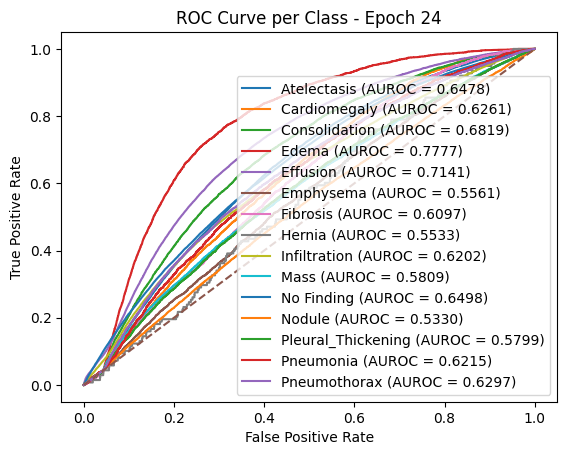

In [11]:
# Zet alles om naar numpy arrays
all_train_preds = np.concatenate(train_preds, axis=0)
all_train_labels = np.concatenate(train_labels, axis=0)
all_val_preds = np.concatenate(val_preds, axis=0)
all_val_labels = np.concatenate(val_labels, axis=0)

# Compute AUROC per klasse
train_auroc = roc_auc_score(all_train_labels, all_train_preds, average=None, multi_class='ovr')
val_auroc = roc_auc_score(all_val_labels, all_val_preds, average=None, multi_class='ovr')

class_names = mlb.classes_  # Dit bevat de namen van de klassen
for i, class_name in enumerate(class_names):
    train_auroc_value = train_auroc[i] if isinstance(train_auroc, np.ndarray) else train_auroc
    val_auroc_value = val_auroc[i] if isinstance(val_auroc, np.ndarray) else val_auroc
    print(f"Class: {class_name} - Train AUROC: {train_auroc_value:.4f} | Val AUROC: {val_auroc_value:.4f}")

# Plot ROC curve per klasse met class names in de label
plt.figure()
if all_val_labels.ndim > 1 and all_val_labels.shape[1] > 0: # Controleer of er meerdere klassen zijn om te plotten
    for i in range(all_val_labels.shape[1]):  # voor elke klasse
        fpr, tpr, _ = roc_curve(all_val_labels[:, i], all_val_preds[:, i])
        val_auroc_for_class = val_auroc[i] if isinstance(val_auroc, np.ndarray) else np.nan # Gebruik NaN als scalar
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {val_auroc_for_class:.4f})')
elif all_val_labels.ndim == 1 or all_val_labels.shape[1] <= 1:
    print("Niet genoeg klassen om ROC curves per klasse te plotten.")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve per Class - Epoch {epoch+1}')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Check aantal voorbeelden per klasse
print("Aantal voorbeelden per klasse in val_labels:")
for i, class_name in enumerate(class_names):
    count = int(np.sum(all_val_labels[:, i]))
    print(f"{class_name}: {count} voorbeelden in val set")
    

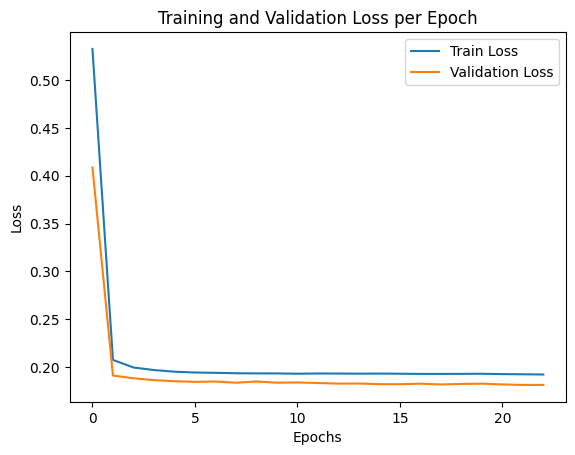

In [12]:
# Plotten van de verliesgrafiek
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()